In [523]:
from __future__ import print_function
import pandas as pd
import numpy as np
import matplotlib.pyplot  as plt
import seaborn as sns
import param_generation as pg
import helpers as hp
from ipywidgets import GridspecLayout,HBox,widgets
from IPython.display import Audio, display
import librosa
import random
import common_vars as commons
import glob


#let's play the sound given the parameters
import imp
imp.reload(pg)
imp.reload(hp)
imp.reload(commons)

sr=41000
classes=commons.classes
classes_ranked=[c+"_rank" for c in classes]
param_cols=['oscType_0',
       'isNoise_0', 'A_0', 'D_0', 'S_0', 'R_0', 'pitch_0_0', 'pitch_1_0',
       'pitch_2_0', 'pitch_3_0', 'bpCutLow_0', 'bpCutHigh_0',
       'bpOrder_0', 'amplitude_0','start_0','length_0']

pc_no_num=[x[0:-2] for x in param_cols] # param columns with no _# 


# df = pd.read_csv("csvs/param_scores.csv",error_bad_lines=False)
df = pd.concat([pd.read_csv(f) for f in glob.glob('csvs/*.csv')], ignore_index = True)

df.columns=[*classes_ranked,*classes,*param_cols]
# df["oscType_0"]=df["oscType_0"].replace(dict(zip(["sine","square","saw"],[0,1,2])))
df=df.fillna(0)
pd.set_option('display.max_columns', 33)


In [2]:
df[classes].describe().loc[["mean","std","25%","75%"]]

,clap,guitar,hat,kick,piano,rim,shake,snare,synth
mean,0.034545,0.133958,0.165379,0.112359,0.060238,0.085400,0.049857,0.089639,0.268624
std,0.042379,0.050491,0.042481,0.066443,0.056003,0.046104,0.046539,0.052050,0.062269
25%,0.000000,0.096683,0.132788,0.068378,0.008636,0.057927,0.003971,0.050194,0.232189
75%,0.056275,0.173049,0.193554,0.153241,0.092389,0.111187,0.080945,0.127780,0.301943


In [3]:
df[classes_ranked].describe().loc[["mean","std","50%"]]
df

,clap_rank,guitar_rank,hat_rank,kick_rank,piano_rank,rim_rank,shake_rank,snare_rank,synth_rank,clap,guitar,hat,kick,piano,rim,shake,...,oscType_0,isNoise_0,A_0,D_0,S_0,R_0,pitch_0_0,pitch_1_0,pitch_2_0,pitch_3_0,bpCutLow_0,bpCutHigh_0,bpOrder_0,amplitude_0,length_0,start_0
0,9.0,6.0,2.0,3.0,8.0,5.0,4.0,7.0,1.0,0.000000,0.091978,0.188168,0.120980,0.020705,0.111562,0.114161,...,0,0,1,0,2,2,32,108,112,32,96,98,2,0,0,9
1,9.0,6.0,2.0,3.0,8.0,5.0,4.0,7.0,1.0,0.000000,0.091978,0.188168,0.120980,0.020705,0.111562,0.114161,...,0,0,1,0,2,2,32,108,112,32,96,98,2,0,0,9
2,6.0,2.0,4.0,8.0,3.0,7.0,9.0,5.0,1.0,0.074175,0.207757,0.122388,0.034445,0.189621,0.040789,0.000000,...,1,1,0,2,2,1,70,56,72,112,36,76,2,0,2,5
3,8.0,2.0,4.0,3.0,7.0,5.0,6.0,9.0,1.0,0.049941,0.165974,0.125021,0.131968,0.084437,0.115868,0.107287,...,0,1,3,2,1,0,34,4,88,112,18,63,2,1,8,1
4,5.0,3.0,2.0,9.0,6.0,8.0,7.0,4.0,1.0,0.110390,0.164440,0.174483,0.000000,0.051145,0.024199,0.047354,...,0,1,3,0,0,0,78,8,48,0,50,103,0,3,6,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48390,8.0,5.0,1.0,7.0,9.0,4.0,3.0,6.0,2.0,0.055607,0.084301,0.211741,0.071589,0.000000,0.145469,0.149757,...,0,1,2,0,3,0,12,36,0,0,112,117,1,2,5,3
48391,9.0,5.0,2.0,4.0,7.0,6.0,8.0,3.0,1.0,0.000000,0.106350,0.154620,0.108202,0.055358,0.093809,0.014243,...,0,0,3,0,0,1,102,32,8,32,46,82,0,2,9,0
48392,9.0,5.0,3.0,2.0,7.0,4.0,8.0,6.0,1.0,0.000000,0.094847,0.152244,0.184860,0.060851,0.106102,0.017574,...,0,0,2,1,0,0,104,20,0,48,4,90,1,2,3,2
48393,9.0,6.0,1.0,3.0,8.0,7.0,4.0,5.0,2.0,0.000000,0.056462,0.263981,0.137058,0.016291,0.039227,0.131588,...,0,1,3,1,1,2,4,60,32,0,104,113,0,1,9,0


<Figure size 1080x540 with 0 Axes>

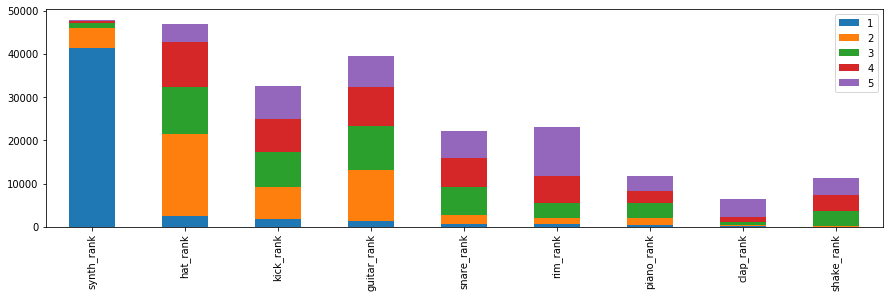

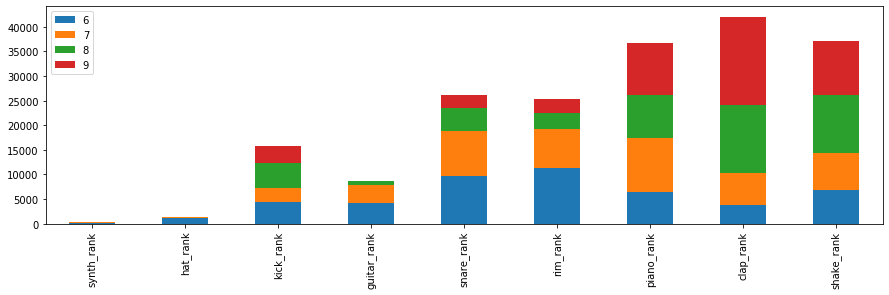

In [4]:
#visualizing ranks per group
gc=pd.DataFrame(columns=range(1,5))
for c in classes_ranked:
    gc=gc.append(df[c].astype(int).value_counts())

gc=gc.sort_values(by=[1,2],ascending=False)
fig = plt.gcf()
fig.set_size_inches(15, 7.5)

gc[list(range(1,6))].plot(kind="bar",figsize=(15,4),stacked=True)

gc[list(range(6,10))].plot(kind="bar",figsize=(15,4),stacked=True)

In [706]:
import imp
imp.reload(pg)
imp.reload(hp)

#Let's hear some of the "best" generated sounds for each group, set g to "sound group" of choice
g="snare"
selection=df[(df[g]>0.2) & (df[g+"_rank"]<3) & (df["synth_rank"]>1)].reset_index(drop=True)
print(selection.shape)

x,y=4,4
grid = GridspecLayout(x, y)
for i in range(x):
    for j in range(y):
        r=selection.iloc[random.randint(0,selection.shape[0]-1)]
        r=r[param_cols]
        pset=hp.rToParams(r)
        out=pg.ensemble([pset])
        o= widgets.Output()
        with o:
            display(Audio(hp.memToAud(out),rate=sr,autoplay=False))
        grid[i, j] = o
display(grid)


(362, 34)


GridspecLayout(children=(Output(layout=Layout(grid_area='widget001')), Output(layout=Layout(grid_area='widget0…

In [6]:
#constructing multivariate distributions to sample from
#get params, get cov matrix, construct distribution
v=selection[param_cols].to_numpy().T
#convert oscType column to 
cov=np.cov(v)
mu=v.mean(1)
#average
pd.DataFrame([mu],columns=param_cols)
selection[param_cols].describe()

,oscType_0,isNoise_0,A_0,D_0,S_0,R_0,pitch_0_0,pitch_1_0,pitch_2_0,pitch_3_0,bpCutLow_0,bpCutHigh_0,bpOrder_0,amplitude_0,length_0,start_0
count,1556.000000,1556.000000,1556.000000,1556.000000,1556.000000,1556.000000,1556.000000,1556.000000,1556.000000,1556.000000,1556.000000,1556.000000,1556.000000,1556.000000,1556.000000,1556.000000
mean,0.238432,0.210154,1.145244,1.561697,1.332905,1.647172,59.553985,52.362468,52.359897,56.688946,17.449871,42.211440,0.937661,1.519923,4.464653,2.198586
std,0.567355,0.407549,1.131023,1.112651,1.155876,1.095826,35.435939,36.418182,36.658838,37.280388,13.340967,20.115094,0.830664,1.118791,2.802050,2.187606
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,28.000000,20.000000,16.000000,16.000000,8.000000,29.000000,0.000000,1.000000,2.000000,0.000000
50%,0.000000,0.000000,1.000000,2.000000,1.000000,2.000000,60.000000,48.000000,48.000000,64.000000,16.000000,37.000000,1.000000,2.000000,4.000000,2.000000
75%,0.000000,0.000000,2.000000,3.000000,2.000000,3.000000,92.000000,84.000000,88.000000,96.000000,24.000000,49.000000,2.000000,3.000000,7.000000,3.000000
max,2.000000,1.000000,3.000000,3.000000,3.000000,3.000000,118.000000,116.000000,112.000000,112.000000,114.000000,119.000000,2.000000,3.000000,9.000000,9.000000


In [519]:
#you can see this approach isn't amazing

def randomSample(t=0):
    p=np.random.multivariate_normal(mu,cov)
    p_dataframed=pd.DataFrame([p],columns=param_cols)
    p_series=p_dataframed.iloc[0][param_cols]
    pset=hp.rToParams(p_series)
    o=pg.ensemble([pset])
    o=librosa.util.normalize(hp.memToAud(o))
    return o,pset,t
o,pset,t=randomSample()
Audio(o,rate=sr,autoplay=True)

/home/asalimi/miniconda3/envs/syn/lib/python3.6/site-packages/IPython/lib/display.py:173: RuntimeWarning: invalid value encountered in true_divide
  scaled = np.int16(data / normalization_factor * 32767).tolist()


In [732]:
#let's try evolution strategys with deap
import scorer
import imp
imp.reload(scorer)
imp.reload(pg)
imp.reload(hp)
from deap import base, creator
import random
from deap import tools
import scipy.spatial.distance as d
from helpers import rToParams

toolbox = base.Toolbox()

creator.create("FitnessMin", base.Fitness, weights=(-1,))
creator.create("Individual", list, fitness=creator.FitnessMin)

def mutateArraySearch(indiv,a):
    e=0.5
    t=0.5
    r=pd.DataFrame([a],columns=param_cols)
    pset=rToParams(r.iloc[0])
    pset.mutate(e,t)
    a_m=list(vars(pset).values())
    return indiv(a_m)

drum="snare"
goodGenes=df[(df[g]>0.15) & (df[g+"_rank"]<3) & (df["synth_rank"]>1)].reset_index(drop=True)

def initPopulation(pcls,ng):
    ipop=[creator.Individual(goodGenes[param_cols].iloc[random.randint(0,goodGenes.shape[0])].values)
          for x in range(ng)]
    return pcls(ipop)

def evaluate(individual):
#     distance=d.minkowski(individual,solution) # distance between params and the "ideal drum"
    ind_df=pd.DataFrame([individual],columns=param_cols)
    p_series=ind_df.iloc[0]

    scores,valid=scorer.rank_score(p_series)
    
    if valid:
        rank=scores["%s_rank"%(drum,)]
        score=scores["%s"%(drum,)]
    else:
        rank=12
        score=0
    f=rank-score
#     print (f,rank,score,"\r",end="")
    return (f,)

def randSelect(l,k):
    return random.sample(l, k)
# toolbox.register("individual_guess", initIndividual, creator.Individual)
toolbox.register("population_guess", initPopulation, list,)

toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("param_mutate",mutateArraySearch,creator.Individual)
toolbox.register("select_best", tools.selBest,fit_attr='fitness')
toolbox.register("select_random",randSelect)
toolbox.register("evaluate", evaluate)
hof=tools.HallOfFame(POP_SIZE*2)

In [735]:
%%time
CXPB, MUTPB = 0.5, 1 #making babies,mutation prob,num generations
MUTENV,MUTTEXT=0.3,0.2
POP_SIZE = 10
hof=tools.HallOfFame(POP_SIZE*2)

def evolve(pop,hof):
        newGenes=toolbox.population_guess(int(0.2*POP_SIZE))
        offspring = pop.copy() + newGenes
        # Clone the selected individuals        
        for i,mutant in enumerate(offspring):
            if random.random() < MUTPB:
#                 print("before mut",offspring[i])
                offspring[i]=toolbox.param_mutate(mutant)
#                 print("after mut ",offspring[i])
                del offspring[i].fitness.values
                
        # Apply crossover and mutation on the offspring
        for child1, child2 in list(zip(offspring[::2], offspring[1::2])):
            if random.random() < CXPB:
                toolbox.mate(child1, child2)
                del child1.fitness.values
                del child2.fitness.values

        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit
        #update hof

        offspring = toolbox.select_best(offspring,POP_SIZE)
        
        hof.update(offspring)
        return offspring

CPU times: user 14 µs, sys: 0 ns, total: 14 µs
Wall time: 17.6 µs


In [738]:
NGEN=30
def main():
#     pop = toolbox.population_guess(POP_SIZE)
    pop=hof.items
    hof.update(pop)
    # Evaluate the entire population
    fitnesses = map(toolbox.evaluate, pop)
    for ind, fit in zip(pop, fitnesses):
        ind.fitness.values = fit
    for g in range(NGEN):
        pop=evolve(pop,hof)
        print (g,"\r",end="")
    return pop
pop=main()

IndexError: single positional indexer is out-of-bounds

In [703]:
def pl(l):
    for p in l:
        print(p,p.fitness)
# pl(pop)
# pop=evolve(pop)
# print("new")
# pl(pop)
# len(pop)
pl(hof)

[0, 1, 2, 0, 0, 3, 48, 96, 72, 0, 8, 115, 2, 2, 5, 4] (0.7900141626596451,)
[0, 0, 0, 2, 0, 0, 104, 88, 96, 64, 30, 45, 0, 1, 0, 0] (1.8126336336135864,)
[0, 0, 0, 3, 2, 3, 88, 96, 72, 0, 26, 84, 2, 2, 5, 0] (1.8169232457876205,)
[1, 0, 0, 0, 3, 2, 88, 8, 56, 0, 30, 92, 0, 0, 1, 0] (1.8209028393030167,)
[0, 0, 2, 1, 2, 1, 88, 56, 112, 0, 26, 84, 2, 1, 6, 0] (1.8260643184185028,)
[0, 0, 1, 0, 0, 1, 104, 88, 56, 0, 28, 49, 0, 3, 2, 1] (1.826608568429947,)
[0, 0, 3, 2, 3, 2, 88, 96, 72, 0, 26, 84, 2, 0, 6, 3] (1.8282044529914856,)
[0, 0, 2, 0, 3, 0, 96, 112, 104, 0, 38, 97, 1, 2, 5, 1] (1.830670177936554,)
[0, 0, 3, 2, 2, 2, 88, 96, 72, 0, 26, 84, 2, 1, 9, 0] (1.8321280181407928,)
[1, 1, 0, 2, 0, 0, 32, 64, 8, 96, 36, 92, 0, 2, 3, 0] (1.8345190584659576,)
[0, 0, 3, 1, 1, 3, 80, 40, 40, 0, 82, 86, 0, 3, 0, 4] (1.8362676203250885,)
[0, 0, 0, 1, 3, 3, 80, 40, 80, 0, 44, 99, 2, 1, 9, 0] (1.8392650932073593,)
[0, 0, 1, 0, 0, 1, 88, 56, 112, 96, 36, 92, 2, 0, 9, 0] (1.842145100235939,)
[0, 0, 1

In [686]:
#how does mutation work?

# toolbox.select_random(pop,POP_SIZE//2)
pop=toolbox.population_guess(POP_SIZE)

In [691]:
c1,c2=pop[0],pop[2]
# Select the next generation individuals
toolbox.select(pop, 5)
# # Clone the selected individuals
# offspring = list(map(toolbox.clone, offspring))
# # Apply crossover and mutation on the offspring
# for child1, child2 in list(zip(offspring[::2], offspring[1::2])):
#     if random.random() < CXPB:
#         toolbox.mate(child1, child2)
#         del child1.fitness.values
#         del child2.fitness.values
# print(c1,c2)
# print(tools.cxTwoPoint(c1,c2,))

AttributeError: 'Toolbox' object has no attribute 'select'

In [737]:
# What did our DAEP search return?

z=hof.items.copy()
# z=pop
def mutateArray(a,e=0.5,t=0.5):
    r=pd.DataFrame([a],columns=param_cols)
    pset=rToParams(r.iloc[0])
    pset.mutate(e,t)
    return pset


x,y=4,int((len(z)/4))
grid=[]
grid = GridspecLayout(x, y)
for i in range(x):
    for j in range(y):
        o= widgets.Output()
        sample_number=i+j+(i*(y-1))
        pset=mutateArray(z[sample_number],e=0,t=0)
#         print()
        try:
            out=pg.ensemble([pset])
            with o:
                display(Audio(hp.memToAud(out),rate=sr,autoplay=False,embed=True),evaluate(z[sample_number]))
            grid[i, j] = o
        except:
            continue
display(grid)

GridspecLayout(children=(Output(layout=Layout(grid_area='widget001')), Output(layout=Layout(grid_area='widget0…